# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from Inference import Inference
from Subspace import Subspace
from model import Model
from util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.7321094609157
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.954586390884565
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.35417699419094
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.779125916898224
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866592
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.0920445

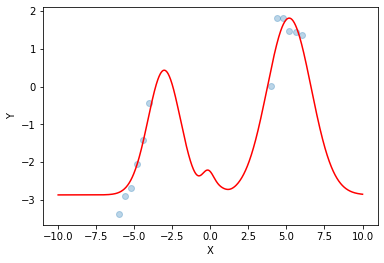

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');

In [4]:
output_noise = 0.5**2
def log_likelihood(y_actual, y_pred):
    return -0.5 * np.log(2 * np.pi * output_noise) - 0.5 * np.mean(((y_actual - y_pred)**2).sum(axis = 1)) / output_noise

## Random

In [5]:
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [6]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [7]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 99.5 with step size 0.001
HMC 400: accept rate of 99.5 with step size 0.0024913851209711485
HMC 600: accept rate of 99.5 with step size 0.003991385120971149
HMC 800: accept rate of 98.625 with step size 0.005491385120971149
HMC 1000: accept rate of 98.9 with step size 0.006764259620958473
HMC 1200: accept rate of 98.75 with step size 0.008264259620958473
HMC 1400: accept rate of 98.78571428571429 with step size 0.009764259620958473
HMC 1600: accept rate of 97.375 with step size 0.011064268706125516
HMC 1800: accept rate of 96.94444444444444 with step size 0.012564268706125516
HMC 2000: accept rate of 95.7 with step size 0.014064268706125515
HMC 2200: accept rate of 95.04545454545455 with step size 0.014740077380072476
HMC 2400: accept rate of 94.125 with step size 0.014544006562384722
HMC 2600: accept rate of 93.11538461538461 with step size 0.014141356189619857
HMC 2800: accept rate of 91.75 with step size 0.014268185513018446
HMC 3000: accept rate of 90.833333

In [8]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 9.57 min


In [9]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

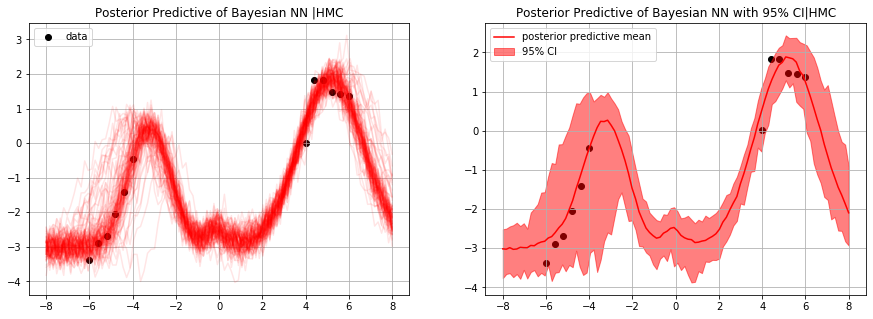

In [10]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

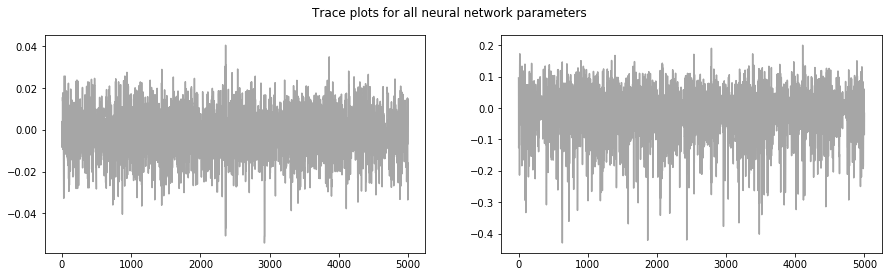

In [11]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [12]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -9.9284


## PCA

In [13]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [14]:
hmc_tune_params={'step_size':5e-2,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [15]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=5)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)


In [16]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.05
HMC 400: accept rate of 100.0 with step size 0.05149590628513469
HMC 600: accept rate of 100.0 with step size 0.05299590628513469
HMC 800: accept rate of 100.0 with step size 0.05449448304423065
HMC 1000: accept rate of 99.9 with step size 0.05599448304423065
HMC 1200: accept rate of 99.91666666666667 with step size 0.057493318828562366
HMC 1400: accept rate of 99.92857142857143 with step size 0.05899331882856237
HMC 1600: accept rate of 99.9375 with step size 0.060491307848387584
HMC 1800: accept rate of 99.94444444444444 with step size 0.061991307848387585
HMC 2000: accept rate of 99.95 with step size 0.06348952546446875
HMC 2200: accept rate of 99.95454545454545 with step size 0.06498566052361361
HMC 2400: accept rate of 99.95833333333334 with step size 0.06648323861727212
HMC 2600: accept rate of 99.96153846153845 with step size 0.067973645140047
HMC 2800: accept rate of 99.96428571428572 with step size 0.06947264431418144
HMC 3000:

In [17]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 7.92 min


In [18]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

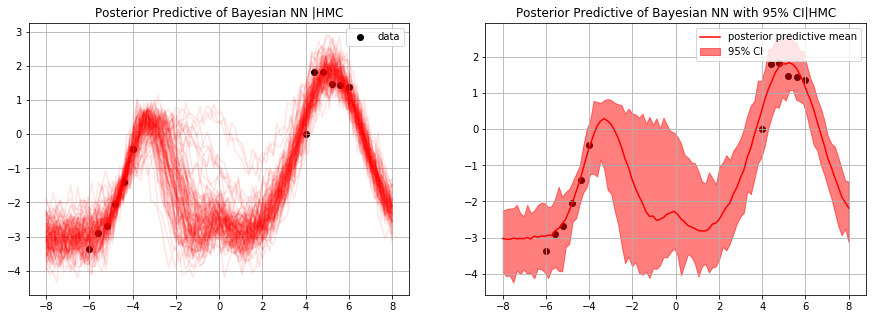

In [19]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
plt.show()

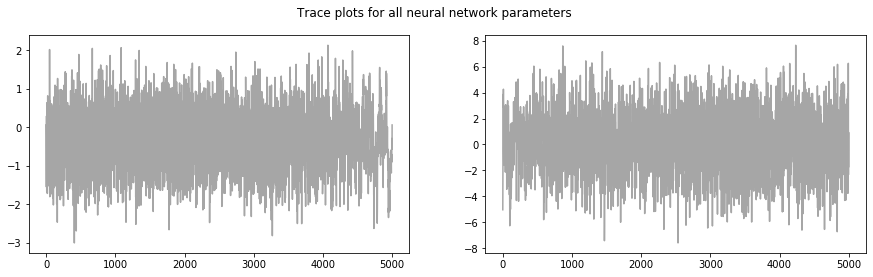

In [20]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [21]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca))

The Posterior Predictive Log likelihood of the observed data is -4.3521


## PCA (extension)

In paper, the deviation matrix is updated during equal epoch intervals. However, to construct a more precise subspace, it's natural for us to have the hypothesis that forming the projection matrix $P$ with the PCA component of the smallest deviation could be better than that of the equal-interval deviations. 

To formulate the hypothesis, we define the expressions as follows:
<br>$w0$: pretrained weights;
<br>$\eta$: learning rate;
<br>$T$: number of steps;
<br>$c$: moment update frequency;
<br>$M$: maximum number of columns in deviation matrix;
<br>$K$: rank of PCA approximation;
<br>$A$: deviation matrix;
<br>$P$: projection matrix for subspace


The original algorithm to construct subspace with PCA goes as follows:

<p style="text-align: right">step0 [Initialize mean] </p>
<br>$w_{SWA} \leftarrow w_0$
<p style="text-align: right">step1 [SGD Update]</p>
<br>for $i\leftarrow1,2,\cdots, T \text{ do}$
<br>$\quad$ $w_i \leftarrow w_{i-1} - \eta \nabla_{w}\mathcal{L}(w_{i-1})$
<p style="text-align: right">step2 [SWA Update]</p>
<br>$\quad$ if MOD$(i,c)=0$ then
<br>$\quad\quad$ $n\leftarrow i/c$
<br>$\quad\quad$ $w_{SWA}\leftarrow \frac{nw_{SWA} + w_i}{n+1}$
<p style="text-align: right">step3 [devation matrix Update]</p>
<br>$\quad\quad$ if NUM_COLS($A$) = $M$ then
<br>$\quad\quad\quad$ REMOVE_COL($A$[:,1])
<br>$\quad\quad$ APPEND_COLS($A$, $w_i - \bar{w}$)
<p style="text-align: right">step4 [Truncated SVD]</p>
<br>$U,S,V^{T}\leftarrow SVD(A)$
<br>return $\hat{w} = w_{SWA}$, $P = SV^T$

In our algorithm, we construct the deviation matrix with the smallest $M$ deviations. The main difference betweem our algorithm and the paper lies in step3 (deviation matrix update process). One difficulty of our algorithm is how to find the minimum $M$ deviations with an efficient use of memory. That is to say, if we first store all possible devations in a matrix and then pick the smallest deviations, there will be a high demand for memory which makes our algorithm hard to scale up. Therefore, we come up with a training in on-line fashion, that is to construct a matrix which stores the smallest $M$ deviations so far and keep updating the matrix when new deviations come in. Under this method, the maximum of the use of memory is $M$, which is the same as theirs. To be more specific, our algorithm goes as below:
<p style="text-align: right">step0 [Initialize mean] </p>
<br>$w_{SWA} \leftarrow w_0$
<p style="text-align: right">step1 [SGD Update]</p>
<br>for $i\leftarrow1,2,\cdots, T \text{ do}$
<br>$\quad$ $w_i \leftarrow w_{i-1} - \eta \nabla_{w}\mathcal{L}(w_{i-1})$
<p style="text-align: right">step2 [SWA Update]</p>
<br>$\quad$ if MOD$(i,c)=0$ then
<br>$\quad\quad$ $n\leftarrow i/c$
<br>$\quad\quad$ $w_{SWA}\leftarrow \frac{nw_{SWA} + w_i}{n+1}$
<p style="text-align: right"><b>step3 [devation matrix Update]</b></p>
<br>$\quad\quad$ if NUM_COLS($A$) = $M$ then
<br>$\quad\quad\quad$ if norm($w_i - \bar{w}$) < norm(A[:,-1]) then
<br>$\quad\quad\quad\quad$ REMOVE_COL($A$[:,-1])
<br>$\quad\quad\quad\quad$ APPEND_COLS($A$, $w_i - \bar{w}$)
<br>$\quad\quad\quad\quad$ SORT_BY_NORM($A$, ascending=True)
<br>$\quad\quad$ else:
<br>$\quad\quad\quad$ APPEND_COLS($A$, $w_i - \bar{w}$)
<br>$\quad\quad\quad$ SORT_BY_NORM($A$, ascending=True)
<p style="text-align: right">step4 [Truncated SVD]</p>
<br>$U,S,V^{T}\leftarrow SVD(A)$
<br>return $\hat{w} = w_{SWA}$, $P = SV^T$

### the smallest deviations

In [22]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y, method='S') # chose the method as L
P, w = my_subspace.get_space()

In [23]:
hmc_tune_params={'step_size':5e-2,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [24]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=5)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)


In [25]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.05
HMC 400: accept rate of 100.0 with step size 0.05149605792925664
HMC 600: accept rate of 100.0 with step size 0.05299605792925664
HMC 800: accept rate of 99.875 with step size 0.054496057929256644
HMC 1000: accept rate of 99.8 with step size 0.055996057929256646
HMC 1200: accept rate of 99.83333333333333 with step size 0.0574947659062378
HMC 1400: accept rate of 99.85714285714286 with step size 0.05898888637377429
HMC 1600: accept rate of 99.875 with step size 0.06048835268356851
HMC 1800: accept rate of 99.8888888888889 with step size 0.06198835268356851
HMC 2000: accept rate of 99.9 with step size 0.0634883526835685
HMC 2200: accept rate of 99.90909090909092 with step size 0.06497280104637061
HMC 2400: accept rate of 99.91666666666667 with step size 0.06647280104637061
HMC 2600: accept rate of 99.92307692307692 with step size 0.06796592043713326
HMC 2800: accept rate of 99.92857142857143 with step size 0.06946380836921373
HMC 3000: ac

In [26]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 10.91 min


In [27]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

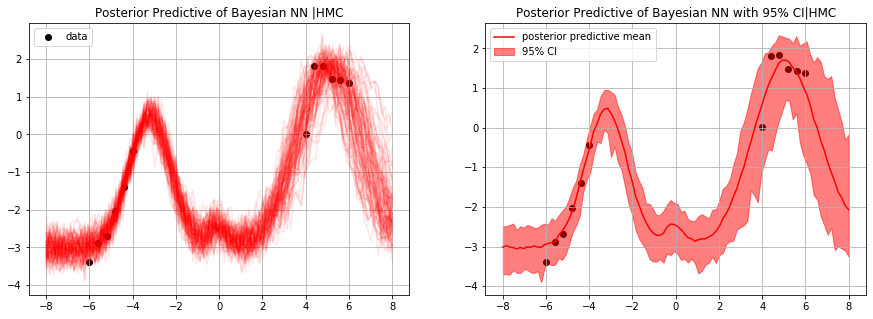

In [28]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

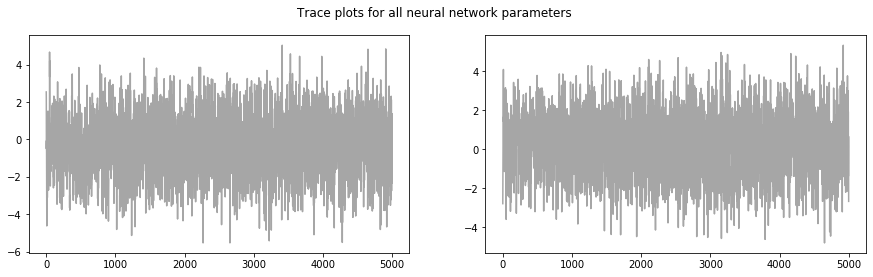

In [29]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

In [30]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca_smallest = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca_smallest))

The Posterior Predictive Log likelihood of the observed data is -4.7667


From the test statistics above we can see that PCA with our extension of the smallest deviations does a job as good as the PCA with equal interval published in the paper. However from the posterior predictive plots above, PCA with equal interval is more informative. 

`[补充一下为什么smallest deviations没有equal deviation好以及update一下hypothesis]`

To fully test our hypothesis, we also examine PCA's behavior with the larget deviations. Under our hypothesis, this method should have the worst performance both in visualization as well as in test statistics as it captures more unrelavant information in constructing the subspace from those large deviations.

### the largest deviations

In [4]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y, method='L') # chose the method as L
P, w = my_subspace.get_space()

In [5]:
hmc_tune_params={'step_size':5e-2,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [6]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=5)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)


In [7]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 0.0 with step size 0.05
HMC 400: accept rate of 0.0 with step size 0.0475
HMC 600: accept rate of 0.0 with step size 0.045
HMC 800: accept rate of 0.0 with step size 0.042499999999999996
HMC 1000: accept rate of 0.0 with step size 0.039999999999999994
HMC 1200: accept rate of 0.0 with step size 0.03749999999999999
HMC 1400: accept rate of 0.0 with step size 0.03499999999999999
HMC 1600: accept rate of 0.0 with step size 0.03249999999999999
HMC 1800: accept rate of 0.0 with step size 0.02999999999999999
HMC 2000: accept rate of 0.05 with step size 0.02749999999999999
HMC 2200: accept rate of 0.09090909090909091 with step size 0.02499999999999999
HMC 2400: accept rate of 3.208333333333333 with step size 0.022499999999999992
HMC 2600: accept rate of 8.269230769230768 with step size 0.019999999999999993
HMC 2800: accept rate of 12.714285714285714 with step size 0.019623682229304676
HMC 3000: accept rate of 15.7 with step size 0.022123682229304675
HMC 3200: accept ra

In [8]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 9.73 min


In [9]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

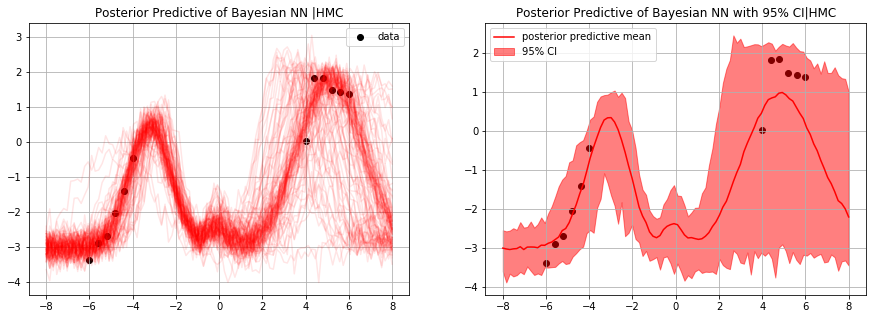

In [10]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

In [18]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca_largest = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca_largest))

The Posterior Predictive Log likelihood of the observed data is -34.6261


From the plots and test statistics above we can see that PCA with largest deviations does the worst job indeed.

## Comparison

From all the traceplots and documented time above, we can see that all our HMC and BBB sampler has converged in around 10 minutes.
`[这一段主要是想和不reduce dimension做比较（时间和converge的效果）,我明天继续train一下]`

From all the posterior predictive plots above we can see that the one from PCA (especially PCA with HMC as inference method) has the most meaningful visualization over uncertainty. To be more specific, it has clearly displayed both aleatoric uncertainty and epistemic uncertainty: it has a wider range of uncertainty over the area where has little data and small narrower range over the area where has more data. By contrast, random subspace construct the projection matrix by random, which by nature can not fully reveal and distinguish those two kinds of uncertainties. 

From all the posterior predictive log-likelihood we can see that PCA (HMC: -4.3521; BBB: -2.7449) does the best job, and PCA with smallest deviation also does a great job (HMC: -4.7667; BBB: -2.9177), and then comes random subspace (HMC: -9.9284; BBB: -58.2702) and PCA with the largest deviation (HMC: -34.6261; BBB: -45.7271). 